In [22]:
import os
import numpy as np
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.mask import mask
from rasterio.features import rasterize
from rasterio.plot import show
from rasterio.warp import Resampling
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import box
from shapely.affinity import translate
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Polygon as MplPolygon
from skimage import measure
from skimage.morphology import binary_opening, disk
from scipy.ndimage import binary_fill_holes
import psutil
import time
import threading

In [23]:
def load_and_resample_band(band_path, transform, height, width, geometries, resampling=Resampling.bilinear):
    """
    Load a band and resample it to a given resolution and extent.

    Args:
        band_path (str): Path to the band file.
        transform (Affine): Affine transformation to apply to the band.
        height (int): Height of the resampled band.
        width (int): Width of the resampled band.
        geometries (list): List of geometries to crop the band to.
        resampling (Resampling): Resampling method to use.

    Returns:
        np.ndarray: Resampled band data.
    """
    with rasterio.open(band_path) as src:
        with WarpedVRT(src, transform=transform, width=width, height=height, resampling=resampling) as vrt:
            band_data, _ = mask(vrt, geometries, crop=True)
    return np.squeeze(band_data)

In [24]:
def analyze_month(month_path, geometries, bands, ref_transform, ref_height, ref_width):
    """
    Analyze Sentinel-2 images for a specific month.
    
    Args:
        month_path (str): Path to the month folder.
        geometries (list): List of geometries to crop the bands to.
        bands (list): List of bands to analyze.
        ref_transform (Affine): Affine transformation to apply to the bands.
        ref_height (int): Height of the resampled bands.
        ref_width (int): Width of the resampled bands.

    Yields:
        tuple: Tuple containing the resampled bands and the valid mask.
    """
    band_data = {}
    
    for date_folder in os.listdir(month_path):
        date_path = os.path.join(month_path, date_folder)
        if not os.path.isdir(date_path):
            continue
        
        # Load bands
        for band in bands:
            band_path = os.path.join(date_path, f"{band}.tif")
            if os.path.exists(band_path):
                band_data[band] = load_and_resample_band(
                    band_path, ref_transform, ref_height, ref_width, geometries,
                    Resampling.nearest if band == "SCL" else Resampling.bilinear
                )
        
        if "SCL" in band_data:
            valid_mask = (band_data["SCL"] == 4) | (band_data["SCL"] == 3)  # Select 'vegetation' and 'cloud shadows' classes only
            for key in band_data:
                if key != "SCL":
                    band_data[key] = band_data[key].astype(np.float32)  # Convert to float to allow NaN
                    band_data[key][~valid_mask] = np.nan
            
            # Return resampled bands for stacking
            yield np.stack([band_data[band] for band in bands[:-1]], axis=-1), valid_mask
            

In [25]:
def aggregate_bands(data_folder, months, bands, geometries, ref_transform, ref_height, ref_width):
    """
    Aggregate bands for multiple months.
    
    Args:
        data_folder (str): Path to the data folder.
        months (tuple): Tuple containing the start and end month to analyze.
        bands (list): List of bands to analyze.
        geometries (list): List of geometries to crop the bands to.
        ref_transform (Affine): Affine transformation to apply to the bands.
        ref_height (int): Height of the resampled bands.
        ref_width (int): Width of the resampled bands.

    Returns:
        tuple: Tuple containing the aggregated bands and the valid mask.
    """
    sum_bands = None
    valid_counts = None
    start_month, end_month = months
    
    for month in range(start_month, end_month + 1):
        month_path = os.path.join(data_folder, str(month))
        for stacked_bands, valid_mask in analyze_month(month_path, geometries, bands, ref_transform, ref_height, ref_width):
            if sum_bands is None:
                sum_bands = np.zeros_like(stacked_bands)
                valid_counts = np.zeros(valid_mask.shape, dtype=int)
            
            sum_bands[valid_mask] += np.nan_to_num(stacked_bands)[valid_mask]
            valid_counts[valid_mask] += 1
    
    mean_bands = np.divide(
        sum_bands, valid_counts[:, :, np.newaxis], where=valid_counts[:, :, np.newaxis] > 0
    )
    return mean_bands, valid_counts > 0

In [26]:
def pca_and_cluster(mean_bands, valid_mask, max_clusters=20):
    """
    Perform PCA and clustering.
    
    Args:
        mean_bands (np.ndarray): Mean bands.
        valid_mask (np.ndarray): Valid mask.
        max_clusters (int): Maximum number of clusters.

    Returns:
        tuple: Tuple containing the cluster labels and the optimal number of clusters.
    """
    valid_pixels = mean_bands[valid_mask]
    standardized_data = StandardScaler().fit_transform(valid_pixels)
    
    pca = PCA(n_components=3)
    pca_data = pca.fit_transform(standardized_data)

    # Print PCA attributes
    print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Explained Variance: {pca.explained_variance_}")
    print(f"PCA Components (loadings): {pca.components_}")
    print(f"PCA Mean: {pca.mean_}")
    print(f"PCA Noise Variance: {pca.noise_variance_}")
    
    # Determine optimal number of clusters using elbow method
    inertia = []
    for n in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, init="k-means++", random_state=0).fit(pca_data)
        inertia.append(kmeans.inertia_)
    
    optimal_clusters = KneeLocator(range(1, max_clusters + 1), inertia, curve="convex", direction="decreasing").elbow

    # Plot elbow chart and mark optimal clusters
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o', label="Inertia")
    plt.axvline(optimal_clusters, color="red", linestyle="--", label=f"Optimal Clusters: {optimal_clusters}")
    plt.xlabel("Number of Clusters")
    plt.xticks(range(1, max_clusters + 1))
    plt.ylabel("Inertia")
    plt.title("Determining Optimal Clusters: Elbow Method")
    plt.legend()
    plt.grid()
    plt.savefig("elbow_chart.png")
    plt.show()

    # Perform clustering with optimal clusters
    final_kmeans = KMeans(n_clusters=optimal_clusters, init="k-means++", random_state=0).fit(pca_data)
    return final_kmeans.labels_, optimal_clusters

In [27]:
def calculate_croptypes_statistics(gdf, note, crop_type_column="cluster_id"):
    """
    Calculate crop type statistics.

    Args:
        gdf (GeoDataFrame): GeoDataFrame containing the field geometries.
        note (str): Note to add to the crop type statistics.
        crop_type_column (str): Column name containing the crop type.

    Returns:
        None
    """
    # Ensure GeoDataFrame is in a projected CRS for accurate area calculation
    if gdf.crs.is_geographic:
        gdf = gdf.to_crs(epsg=32617)  # UTM zone for Michigan
    
    # Calculate acreage and convert square meters to acres (1 square meter = 0.000247105 acres)
    gdf['acreage'] = gdf.geometry.area * 0.000247105
        
    # Aggregate acreage and count by crop type
    crop_stats = gdf.groupby(crop_type_column)['acreage'].agg(['sum', 'count']).reset_index()

    # Rename the "Crop Type" values as "Crop n+1"
    crop_stats[crop_type_column] = crop_stats[crop_type_column].apply(lambda x: f"Crop {x + 1}")

    # Round the "Total Acreage (acres)"" column to 2 decimal places
    crop_stats['sum'] = crop_stats['sum'].round(2)

    # Add total acreage and field count
    total_acreage = crop_stats['sum'].sum()
    total_fields = crop_stats['count'].sum()
    
    # Print crop type statistics
    print(f"\nCrop Type Statistics {note}:")
    print(crop_stats.rename(columns={crop_type_column: "Crop Type", "sum": "Total Acreage (acres)",
                                     "count": "Number of Fields"}).to_string(index=False))
    print(f"\nTotal Acreage: {total_acreage:.2f} acres")
    print(f"Total Number of Fields: {total_fields}")

In [28]:
def create_polygons(labels, valid_mask, transform, crs, cluster_column="cluster_id", min_area=4000):
    """
    Create polygons from clustering labels and clean the polygons.
    
    Args:
        labels (np.ndarray): Cluster labels.
        valid_mask (np.ndarray): Valid mask.
        transform (Affine): Affine transformation.
        crs (str): CRS of the GeoDataFrame.
        cluster_column (str): Column name for the cluster ID.
        min_area (int): Minimum area threshold for polygons.

    Returns:
        GeoDataFrame: GeoDataFrame containing the polygons.
    """
    spatial_labels = np.full(valid_mask.shape, -1, dtype=int)
    spatial_labels[valid_mask] = labels
    polygons = []

    for cluster_id in np.unique(spatial_labels):
        if cluster_id == -1:  # Skip invalid regions
            continue
        poly_mask = spatial_labels == cluster_id

        # Fill holes and smooth boundaries
        poly_mask = binary_fill_holes(poly_mask)
        poly_mask = binary_opening(poly_mask, disk(2))

        contours = measure.find_contours(poly_mask.astype(float), 0.5)
        for contour in contours:
            poly_coords = [transform * (x, y) for y, x in contour]
            polygon = Polygon(poly_coords)
            if polygon.is_valid and polygon.area >= min_area:  # Threshold for polygons
                # Handle MultiPolygon geometries
                if isinstance(polygon, MultiPolygon):
                    for single_polygon in polygon.geoms:
                        if single_polygon.area >= min_area:  # Threshold for sub-polygons
                             polygons.append({"geometry": single_polygon, cluster_column: cluster_id})
                else:
                    polygons.append({"geometry": polygon, cluster_column: cluster_id})

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(polygons, geometry="geometry", crs=crs)

    # Print polygon statistics
    calculate_croptypes_statistics(gdf, "(After Creating Polygons)")

    return gdf

In [29]:
def plot_clusters(labels, global_valid_mask, output_name):
    """
    Plot identified clusters.
    
    Args:
        labels (np.ndarray): Cluster labels.
        global_valid_mask (np.ndarray): Global valid mask.
        output_name (str): Output file name.

    Returns:
        None
    """
    labeled_array = np.zeros_like(global_valid_mask, dtype=np.int32)
    labeled_array[global_valid_mask] = labels + 1  # Offset clusters to start from 1 for visibility

    num_clusters = np.max(labeled_array)

    plt.figure(figsize=(10, 6))
    plt.imshow(labeled_array, cmap=plt.get_cmap("tab20", num_clusters + 1))

    boundaries = np.arange(-0.5, num_clusters + 1, 1)  # Define boundaries for each color
    cbar = plt.colorbar(label="Cluster ID", orientation="horizontal", boundaries=boundaries, ticks=np.arange(0, num_clusters + 1))

    tick_labels = ["Non-vegetation"] + [f"Cluster {i}" for i in range(1, num_clusters + 1)]
    cbar.set_ticklabels(tick_labels)   

    plt.title("Identified Clusters")
    plt.xlabel("Pixel X")
    plt.ylabel("Pixel Y")
    plt.savefig(output_name, dpi=600, bbox_inches="tight")
    plt.show()
    

In [30]:
def plot_identified_fields(gdf, crop_type_column, output_name):
    """
    Plots the identified fields (polygons) by crop type and calculates acreage.
    
    Args:
        gdf (GeoDataFrame): GeoDataFrame containing the field geometries.
        crop_type_column (str): Column name containing the crop type.
        output_name (str): Output file name.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a color map for the crop types
    unique_clusters = sorted(gdf[crop_type_column].unique())
    cmap = plt.get_cmap("Paired", len(unique_clusters))

    # Plot the identified fields by crop type
    gdf.to_crs("EPSG:4326").plot(column=crop_type_column, ax=ax, cmap="Paired",
                                 edgecolor="black", linewidth=0.1, legend=False)

    # Create a custom legend
    legend_elements = [
        Patch(facecolor=cmap(i), edgecolor="black", label=f"Crop {i + 1}")
        for i in range(len(unique_clusters))
    ]
    ax.legend(handles=legend_elements, title="Crop Types", loc="upper right", frameon=True)

    # Set plot title and labels
    ax.set_title("Identified Fields by Crop Type", fontsize=14)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # Save the plot
    plt.savefig(output_name, dpi=600, bbox_inches="tight")
    plt.show()

    # Print crop type statistics
    calculate_croptypes_statistics(gdf, "(For Identified Fields)")

In [31]:
def plot_tci_with_field_boundaries(tci_path, gdf, masked_geometries, output_name):
    """"
    Plot the True Color Image (TCI) with identified field boundaries.

    Args:
        tci_path (str): Path to the TCI image.
        gdf (gpd.GeoDataFrame): GeoDataFrame containing the field polygons and crop types.
        masked_geometries (list): List of masked geometries.
        output_name (str): Output file name.

    Returns:
        None
    """
    # Open the TCI image
    with rasterio.open(tci_path) as tci_src:
        tci_crs = tci_src.crs  
        tci_transform = tci_src.transform  
        tci_image, _ = mask(tci_src, masked_geometries, crop=True)  
        tci_image = np.moveaxis(tci_image, 0, -1)  

        # Normalize the TCI image
        tci_image = tci_image.astype(np.float32)
        tci_image /= np.max(tci_image, axis=(0, 1))  

    # Ensure polygons are in the same CRS as the TCI image
    if gdf.crs != tci_crs:
        gdf = gdf.to_crs(tci_crs)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(tci_image, origin='upper')  
    ax.set_title("True Color Image with Identified Field Boundaries", fontsize=14)

    # Overlay field boundaries
    for geometry in gdf.geometry:
        if geometry.is_valid:
            # Handle MultiPolygon geometries
            if isinstance(geometry, MultiPolygon):
                for polygon in geometry.geoms:
                    transformed_coords = [~tci_transform * (x, y) for x, y in polygon.exterior.coords]
                    mpl_polygon = MplPolygon(transformed_coords, fill=False, edgecolor='yellow', linewidth=0.1)
                    ax.add_patch(mpl_polygon)
            else:  # Handle single Polygon geometries
                transformed_coords = [~tci_transform * (x, y) for x, y in geometry.exterior.coords]
                mpl_polygon = MplPolygon(transformed_coords, fill=False, edgecolor='yellow', linewidth=0.1)
                ax.add_patch(mpl_polygon)

    # Customize labels and save the plot
    ax.set_xlabel("Pixel X")
    ax.set_ylabel("Pixel Y")
    plt.savefig(output_name, dpi=600, bbox_inches="tight")
    plt.show()


In [32]:
def fix_and_debug_shift(gt_path, polygons_gdf):
    """
    Fix and debug the alignment shift between the ground truth GeoTIFF and the identified polygons.

    Args:
        gt_path (str): Path to the ground truth GeoTIFF.
        polygons_gdf (gpd.GeoDataFrame): Identified polygons GeoDataFrame.

    Returns:
        None
    """
    # Open the ground truth GeoTIFF
    with rasterio.open(gt_path) as src:
        gt_crs = src.crs
        gt_transform = src.transform
        gt_bounds = src.bounds
        gt_data = src.read(1)  # Read the first band for visualization

        # Create GeoDataFrame for GeoTIFF bounds
        gt_bbox = gpd.GeoDataFrame({"geometry": [box(*gt_bounds)]}, crs=gt_crs)
    
    # Plot the ground truth GeoTIFF and identified polygons
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot ground truth GeoTIFF
    show(gt_data, transform=gt_transform, ax=ax[0], cmap="tab20")
    gt_bbox.boundary.plot(ax=ax[0], color="red", linewidth=2, label="Ground Truth Bounds")
    ax[0].set_title("Ground Truth GeoTIFF with Bounding Box")
    ax[0].legend()

    # Plot identified polygons
    polygons_gdf.boundary.plot(ax=ax[1], color="blue", linewidth=0.5, label="Identified Polygons")
    gt_bbox.boundary.plot(ax=ax[1], color="red", linewidth=2, label="Ground Truth Bounds")
    ax[1].set_title("Identified Polygons with GeoTIFF Bounds (Before Correction)")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Print initial bounds
    print("\n--- Initial Bounding Box ---")
    print(f"Polygons Bounds Before Correction: {polygons_gdf.total_bounds}")

    # Reproject polygons if necessary
    if polygons_gdf.crs != gt_crs:
        polygons_gdf = polygons_gdf.to_crs(gt_crs)

    # Correct the polygons' alignment by adjusting their geometry using the ground truth transform
    # Ensure polygons align with the GeoTIFF transform
    polygons_gdf["geometry"] = polygons_gdf["geometry"].translate(
        xoff=gt_bounds[0] - polygons_gdf.total_bounds[0],
        yoff=gt_bounds[1] - polygons_gdf.total_bounds[1]
    )

    # Validate corrected bounds
    print("\n--- Corrected Bounding Box ---")
    print(f"Polygons Bounds After Correction: {polygons_gdf.total_bounds}")

    # Visualize the corrected alignment
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot ground truth GeoTIFF
    show(gt_data, transform=gt_transform, ax=ax[0], cmap="tab20")
    gt_bbox.boundary.plot(ax=ax[0], color="red", linewidth=2, label="Ground Truth Bounds")
    ax[0].set_title("Ground Truth GeoTIFF with Bounding Box")
    ax[0].legend()

    # Plot corrected polygons
    polygons_gdf.boundary.plot(ax=ax[1], color="blue", linewidth=0.5, label="Corrected Polygons")
    gt_bbox.boundary.plot(ax=ax[1], color="red", linewidth=2, label="Ground Truth Bounds")
    ax[1].set_title("Corrected Polygons with GeoTIFF Bounds (After Correction)")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [33]:
def visualize_croptypes_with_boundaries(ground_truth_path, polygons_gdf, output_name, note):
    """
    Visualize crop types with identified boundaries on the ground truth GeoTIFF.

    Args:
        ground_truth_path (str): Path to the ground truth GeoTIFF.
        polygons_gdf (gpd.GeoDataFrame): Identified polygons GeoDataFrame.
        output_name(str): Path to save the resulting plot.
        note (str): Additional note to include in the plot title.

    Returns:
        None
    """
    with rasterio.open(ground_truth_path) as src:
        # Read GeoTIFF data
        crop_types = src.read(1)
        transform = src.transform

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot the GeoTIFF with a colormap
        cmap = plt.get_cmap("tab20")
        show(crop_types, transform=transform, ax=ax, cmap=cmap,
             title=f"Field Boundary Comparison: Identified vs. Ground Truth {note}")

        # Overlay polygons
        for _, row in polygons_gdf.iterrows():
            if row.geometry.is_valid:
                ax.plot(*row.geometry.exterior.xy, color="red", linewidth=0.1)

        # Add the legend
        ax.plot([], [], color="red", linewidth=0.5, label="Identified Boundaries")
        ax.legend(loc="upper right")

        # Set axis limits to match the extent of the raster (crop out the strip)
        ax.set_xlim([src.bounds[0], src.bounds[2]])
        ax.set_ylim([src.bounds[1], src.bounds[3]])

        # Save and display the plot
        plt.savefig(output_name, dpi=600)
        plt.show()

In [34]:
def compute_metrics(identified_mask, ground_truth_mask, valid_mask):
    """
    Compute evaluation metrics for the identified and ground truth masks.

    Args:
        identified_mask (np.ndarray): Identified mask.
        ground_truth_mask (np.ndarray): Ground truth mask.
        valid_mask (np.ndarray): Valid mask.

    Returns:
        dict: Dictionary containing the evaluation metrics.
    """
    # Create a mask for valid regions
    valid_data = valid_mask & (identified_mask >= 0) & (ground_truth_mask >= 0)

    # Apply the valid_data mask
    true_positive = np.sum((identified_mask == 1) & (ground_truth_mask == 1) & valid_data)
    false_positive = np.sum((identified_mask == 1) & (ground_truth_mask == 0) & valid_data)
    false_negative = np.sum((identified_mask == 0) & (ground_truth_mask == 1) & valid_data)

    # Calculate metrics with edge case handling
    iou = true_positive / (true_positive + false_positive + false_negative) if (true_positive + false_positive + false_negative) > 0 else 0
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Valid mask coverage: {np.sum(valid_mask)}/{valid_mask.size}")
    print(f"Valid data coverage: {np.sum(valid_data)}/{valid_data.size}")
    print(f"True Positive: {true_positive}, False Positive: {false_positive}, False Negative: {false_negative}")

    return {"IoU": iou, "Precision": precision, "Recall": recall, "F1-score": f1_score}

In [35]:
def calculate_metrics_with_croptypes(ground_truth_path, polygons_gdf, note, buffer_distance=0):
    """
    Calculate metrics based on identified crop types and ground truth.

    Args:
        ground_truth_path (str): Path to the ground truth GeoTIFF.
        polygons_gdf (gpd.GeoDataFrame): Identified polygons GeoDataFrame.
        note (str): Note to add to the metrics.
        buffer_distance (float): Buffer distance for polygons.

    Returns:
        None
    """
    with rasterio.open(ground_truth_path) as src:
        # Read GeoTIFF and transform
        crop_types = src.read(1)
        transform = src.transform

        # Apply buffer to polygons
        buffered_polygons = polygons_gdf.geometry.buffer(buffer_distance)

        # Rasterize buffered polygons
        identified_mask = rasterize(
            [(geom, 1) for geom in buffered_polygons if geom.is_valid],
            out_shape=crop_types.shape,
            transform=transform,
            fill=0,
            all_touched=True,
            dtype="uint8"
        )

        # Create masks
        valid_mask = crop_types > 0
        ground_truth_mask = (crop_types > 0).astype(int)

        # Compute metrics
        metrics = compute_metrics(identified_mask, ground_truth_mask, valid_mask)

        # Print metrics
        print(f"Metrics {note}:")
        for key, value in metrics.items():
            print(f"{key}: {value:.4f}")
        
        # Print crop type statistics
        calculate_croptypes_statistics(polygons_gdf, note)

In [36]:
# Start tracking time and create the process instance
start_time = time.time()
process = psutil.Process(os.getpid())

# CPU tracking setup
cpu_samples = []
processing = True

def sample_cpu_usage():
    while processing:
        cpu_samples.append(process.cpu_percent(interval=0.1) / psutil.cpu_count())
        time.sleep(0.5)

cpu_thread = threading.Thread(target=sample_cpu_usage)
cpu_thread.start()

In [37]:
# Data paths and parameters
data_folder = "/data/2022"  # Path to the data folder. Adjust this path as needed.
county_shapefile = "/data/shp_gmu/26063.shp"  # Path to the county shapefile. Adjust this path as needed.
ground_truth_path = os.path.join(data_folder, "cdl_2022.tif")  # Path to the ground truth GeoTIFF. Adjust this path as needed.
months = (8, 8)  # Start and end month to analyze
bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "SCL"]
min_area = 4000  # Minimum area threshold for polygons
image_time = time.strftime("%Y-%m-%d_%H-%M-%S")
tci_path = os.path.join(data_folder, "8/S2A_17TLJ_20220827_0_L2A/TCI.tif")  # Path to the True Color Image (TCI). Adjust this path as needed.
output_cluster_name = f"clusters_{image_time}.png"
output_fields_name = f"identified_fields_by_crop_type_{image_time}.png"
output_tci_name = f"field_boundaries_on_tci_{image_time}.png"
output_comparison_name = f"comparison_results_{image_time}_"

In [38]:
# Load county boundary
county_boundary = gpd.read_file(county_shapefile).to_crs("EPSG:32617")
masked_geometries = [geom for geom in county_boundary.geometry]

In [39]:
# Reference CRS and transform from a sample image
sample_band_path = os.path.join(data_folder, "8/S2A_17TLJ_20220827_0_L2A/B08.tif")  # Sample band path. Adjust this path as needed.
with rasterio.open(sample_band_path) as ref_src:
    ref_crs = ref_src.crs
    ref_transform = ref_src.transform
    ref_height, ref_width = ref_src.shape

Explained Variance Ratio: [0.5169938  0.35021389 0.06579964]
Explained Variance: [6.20392596 4.20256686 0.78959571]
PCA Components (loadings): [[ 0.27304658  0.29843637  0.22887301  0.34411541  0.23075028 -0.22381656
  -0.29874856 -0.29636191 -0.30064091 -0.28979557  0.29285562  0.35359801]
 [ 0.23873895  0.28020241  0.36286732  0.20643217  0.32867956  0.39175465
   0.32003301  0.30973599  0.3154871   0.31295315  0.13886898  0.11656562]
 [ 0.20794477 -0.14147223 -0.35838599 -0.16531246 -0.36357733 -0.01892342
   0.10567075  0.13439075  0.12480973  0.08737624  0.6475821   0.42027069]]
PCA Mean: [ 2.81083157e-14 -5.45161137e-15 -5.90585169e-14  2.12089908e-14
 -7.82440630e-14  3.27068092e-15 -5.24797964e-15  1.48468015e-14
  7.91445702e-16 -3.98250630e-15  2.74327518e-14 -9.60564680e-15]
PCA Noise Variance: 0.0893235655194129


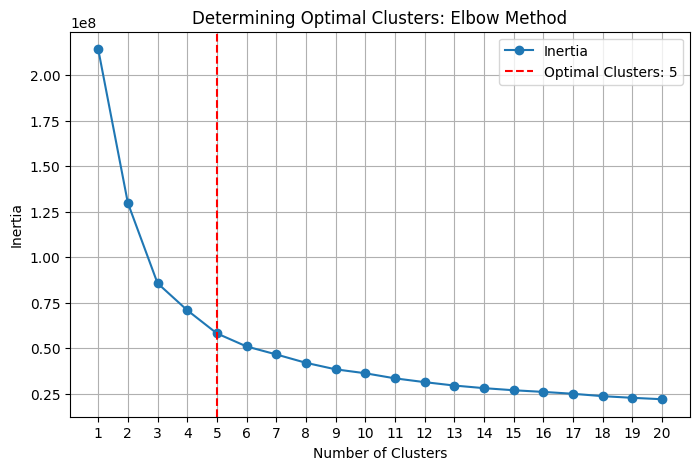


Crop Type Statistics (After Creating Polygons):
Crop Type  Total Acreage (acres)  Number of Fields
   Crop 1              134000.38              4617
   Crop 2              115651.47              6155
   Crop 3               53109.87              3129
   Crop 4               98559.01              3340
   Crop 5               68292.53              2002

Total Acreage: 469613.26 acres
Total Number of Fields: 19243


In [40]:
# Main execution
mean_bands, global_valid_mask = aggregate_bands(data_folder, months, bands, masked_geometries, ref_transform, ref_height, ref_width)
labels, optimal_clusters = pca_and_cluster(mean_bands, global_valid_mask)
polygons_gdf = create_polygons(labels, global_valid_mask, ref_transform, ref_crs, min_area=min_area)

In [41]:
# Stop CPU monitoring
processing = False
cpu_thread.join()

# Output processing time, memory usage, and average CPU usage
print(f"Processing Time: {time.time() - start_time:.2f} seconds")
print(f"Memory Usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")
print(f"Average CPU Usage: {np.mean(cpu_samples):.2f}%")

Processing Time: 484.11 seconds
Memory Usage: 391.45 MB
Average CPU Usage: 18.28%


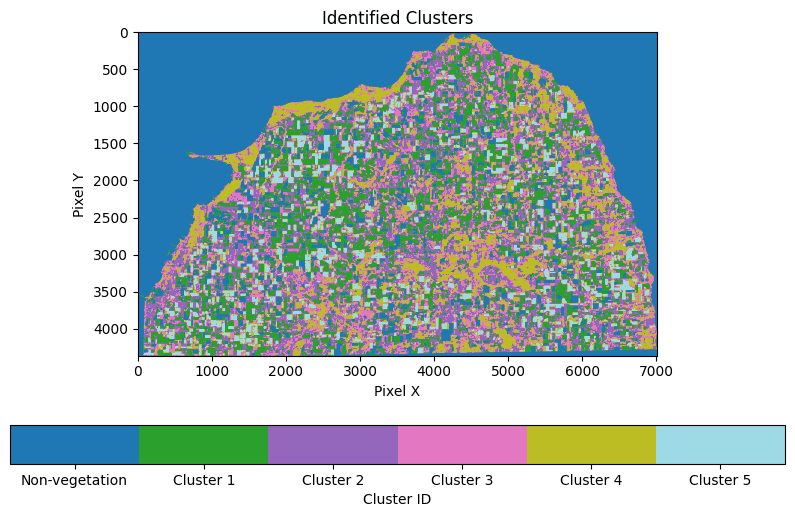

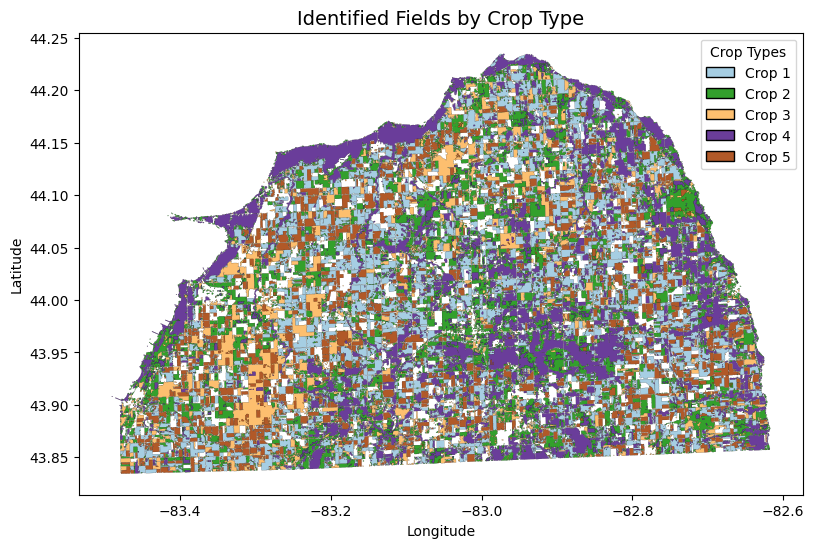


Crop Type Statistics (For Identified Fields):
Crop Type  Total Acreage (acres)  Number of Fields
   Crop 1              134000.38              4617
   Crop 2              115651.47              6155
   Crop 3               53109.87              3129
   Crop 4               98559.01              3340
   Crop 5               68292.53              2002

Total Acreage: 469613.26 acres
Total Number of Fields: 19243


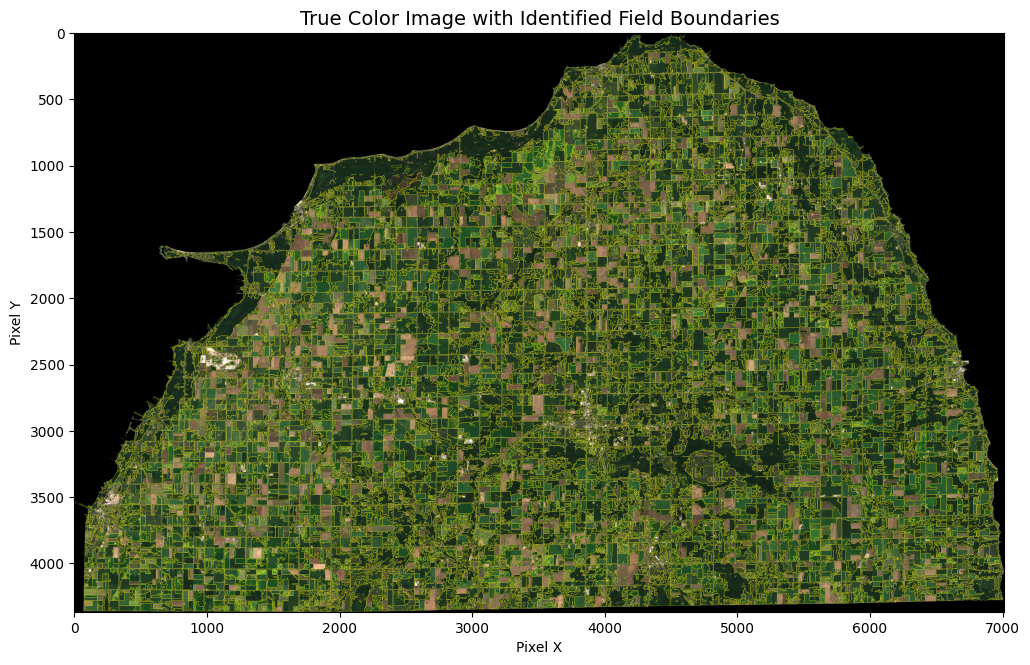

In [42]:
# Plotting and visualization
plot_clusters(labels, global_valid_mask, output_cluster_name)
plot_identified_fields(polygons_gdf, 'cluster_id', output_fields_name)
plot_tci_with_field_boundaries(tci_path, polygons_gdf, masked_geometries, output_tci_name)

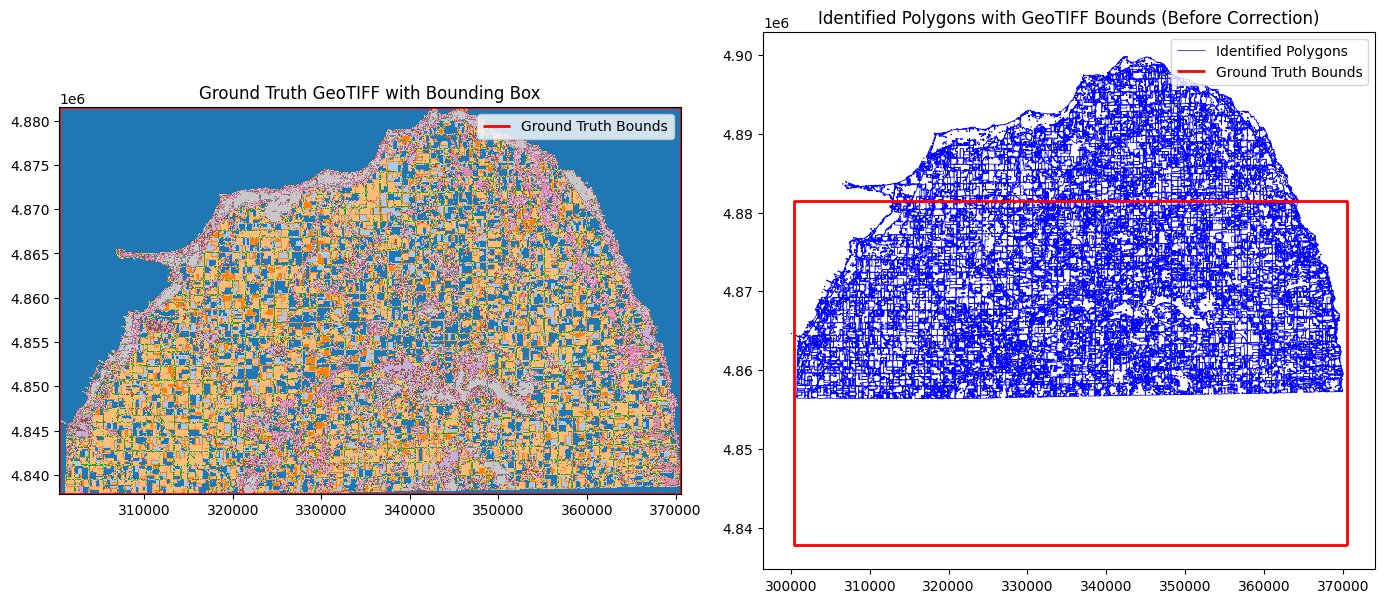


--- Initial Bounding Box ---
Polygons Bounds Before Correction: [ 300000. 4856380.  370095. 4899845.]

--- Corrected Bounding Box ---
Polygons Bounds After Correction: [ 300405. 4837845.  370500. 4881310.]


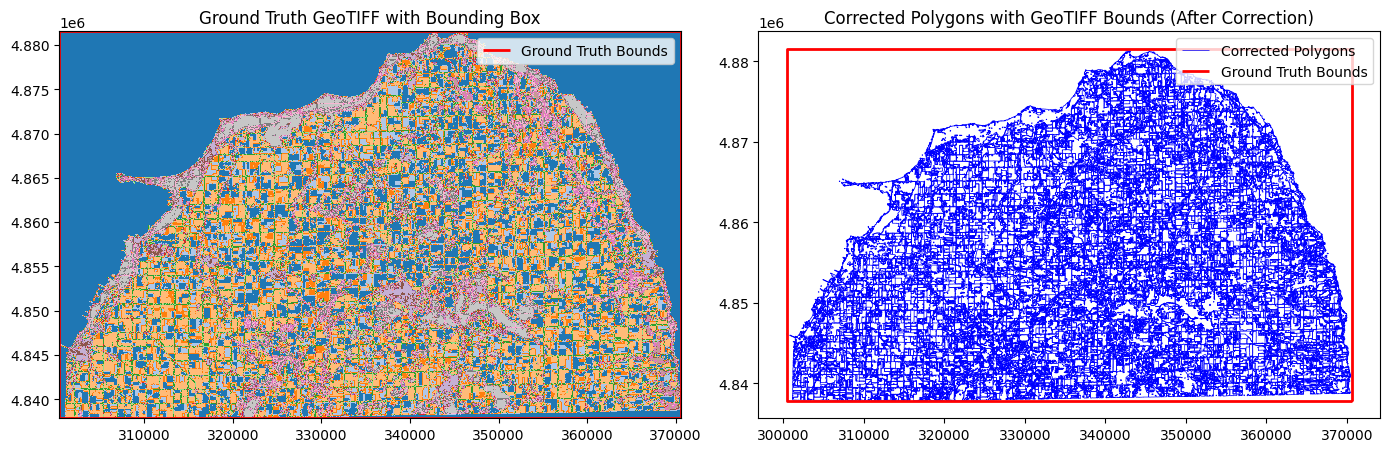

In [43]:
# Identify, fix, and debug the shift issue with the ground truth
fix_and_debug_shift(ground_truth_path, polygons_gdf)

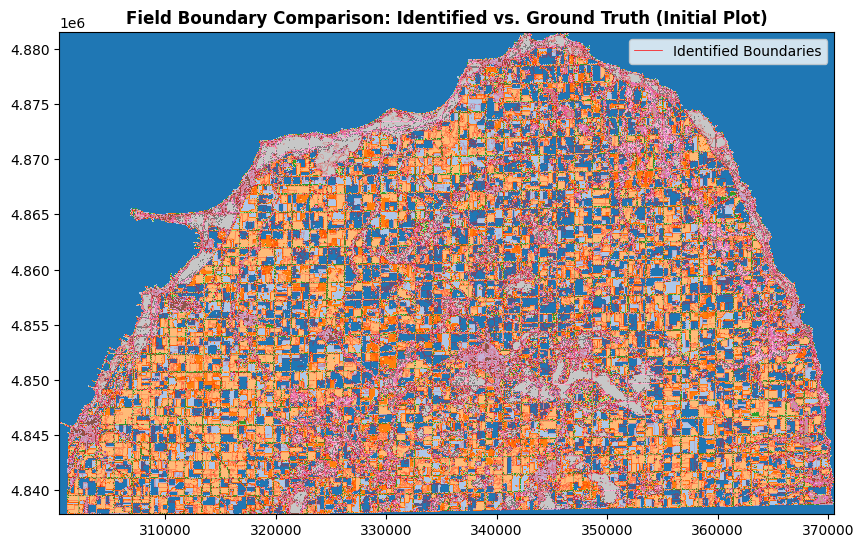

Valid mask coverage: 2405815/3405584
Valid data coverage: 2405815/3405584
True Positive: 2118667, False Positive: 0, False Negative: 287148
Metrics (Initial Plot):
IoU: 0.8806
Precision: 1.0000
Recall: 0.8806
F1-score: 0.9365

Crop Type Statistics (Initial Plot):
Crop Type  Total Acreage (acres)  Number of Fields
   Crop 1              134000.38              4617
   Crop 2              115651.47              6155
   Crop 3               53109.87              3129
   Crop 4               98559.01              3340
   Crop 5               68292.53              2002

Total Acreage: 469613.26 acres
Total Number of Fields: 19243


In [44]:
# Compare identified field boundaries with ground truth
visualize_croptypes_with_boundaries(ground_truth_path, polygons_gdf, f"{output_comparison_name}initial.png", "(Initial Plot)")
calculate_metrics_with_croptypes(ground_truth_path, polygons_gdf, "(Initial Plot)")